<h1> <b> Monkey Species Classification:</b> Neural Network </h1>

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.activations import linear, relu
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2
np.set_printoptions(precision=2)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)



2024-05-13 05:14:51.510175: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 05:14:51.620795: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


<h2> Preparing Data for training: </h2>

In [2]:
train_dir = "./archive/training/training"
val_dir = "./archive/validation/validation"
# Image agmentation and normalization by rescaling
train_data_generator = ImageDataGenerator(
    rescale = 1./255, #Normalize
    horizontal_flip = True,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 2.0,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = "nearest" #fill newly created pizels
)
val_data_generator = ImageDataGenerator(rescale = 1./255) # no agmentation for val data set

#Flow training images using train_datagen

train_generator = train_data_generator.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "sparse"
)

validation_generator = val_data_generator.flow_from_directory(
    val_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "sparse"
)
x_batch, y_batch = next(train_generator)
print(f"Shape of the features: {x_batch.shape}")
print(f"Shape of the target values: {y_batch.shape}")
print(os.listdir(train_dir))

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
Shape of the features: (32, 224, 224, 3)
Shape of the target values: (32,)
['patas_monkey', 'pygmy_marmoset', 'nilgiri_langur', 'mantled_howler', 'bald_uakari', 'common_squirrel_monkey', 'silvery_marmoset', 'japanese_macaque', 'black_headed_night_monkey', 'white_headed_capuchin']


{'bald_uakari': 0, 'black_headed_night_monkey': 1, 'common_squirrel_monkey': 2, 'japanese_macaque': 3, 'mantled_howler': 4, 'nilgiri_langur': 5, 'patas_monkey': 6, 'pygmy_marmoset': 7, 'silvery_marmoset': 8, 'white_headed_capuchin': 9}


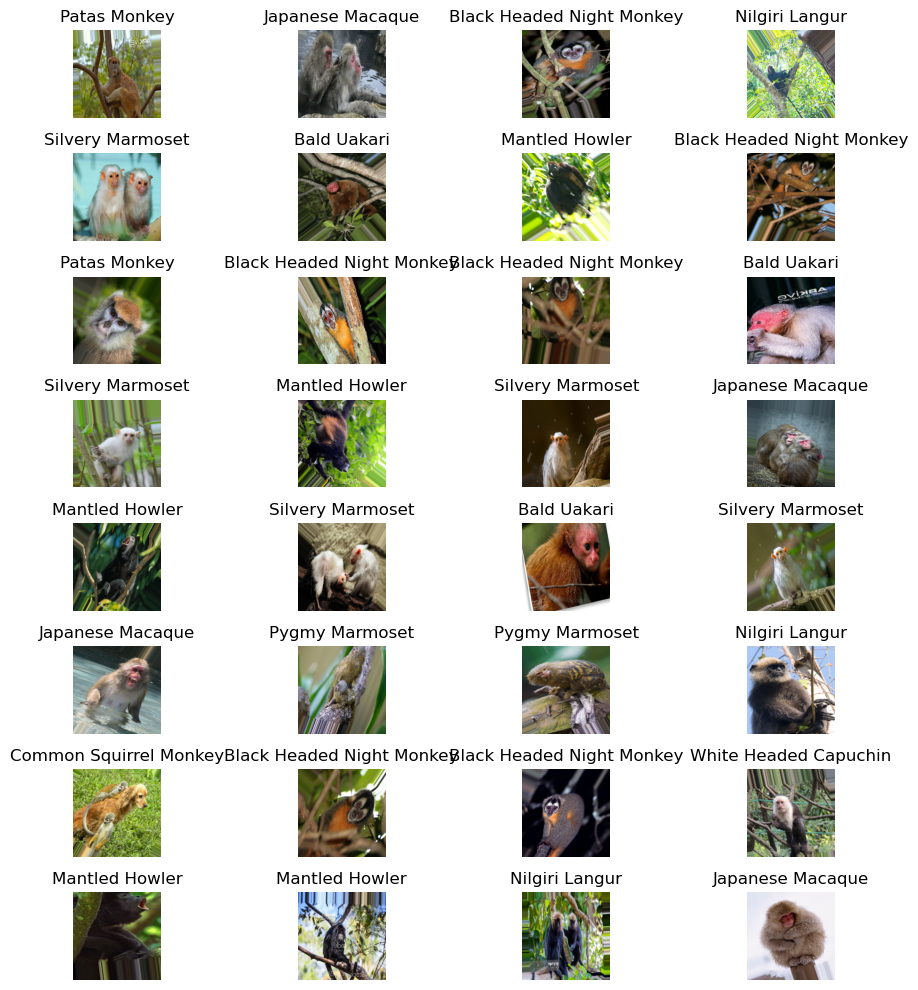

In [3]:
species_dictionary = {
    0 : "Bald Uakari",
    1 : "Black Headed Night Monkey",
    2 : "Common Squirrel Monkey",
    3 : "Japanese Macaque",
    4 : "Mantled Howler",
    5 : "Nilgiri Langur",
    6 : "Patas Monkey",
    7 : "Pygmy Marmoset",
    8 : "Silvery Marmoset",
    9 : "White Headed Capuchin"
    }
print(train_generator.class_indices)
# Fetch a batch of images and labels from the generator
x_batch, y_batch = next(train_generator)

batch_size = x_batch.shape[0]

fig, ax = plt.subplots(int(batch_size / 4), 4, figsize=(10, 10))
# If we have more axes than images, flatten the array and turn off the excess axes
ax = ax.flatten()

for i in range(batch_size):
    img = x_batch[i]
    target = y_batch[i]

    ax[i].imshow(img)

    # Set the title of the subplot to the class index
    ax[i].set_title(species_dictionary.get(target, 0))
    ax[i].axis('off')

plt.tight_layout()
plt.show()


<h2> Multi Classification Neural Network TensorFlow Implementation: </h2>

In [4]:
tf.random.set_seed(1234)
# Comment and uncomment code to experiment with layers
model = Sequential(
    [
        Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 3)), #param 1 = num of filters param 2 = size of filters
        MaxPooling2D((2,2)), # makes small window that slides across feature map
        Conv2D(64, (3, 3), activation = "relu"), #was 64
        MaxPooling2D((2,2)),
        Conv2D(128, (3, 3), activation = "relu"),
        MaxPooling2D((2,2)),
        Flatten(), #turns multi-demensional input into one-dimentional array
        Dense(224, activation = "relu", kernel_regularizer = L2(0.00001)),
        Dropout(0.5), #temporarily dropout neurons during each training pass to prevent overfitting  
        Dense(units = 10, activation = "linear")
    ], name = "monkey_classification"
)

2024-05-13 05:14:55.130703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 05:14:55.270356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 05:14:55.270403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 05:14:55.271118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AV

In [5]:
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name}")
    if hasattr(layer, "get_weights"):
        weights = layer.get_weights()
        if weights:
            W, b = weights
            print(f"W{i} shape = {W.shape}, b{i} shape = {b.shape}")
model.summary()

Layer 0: conv2d
W0 shape = (3, 3, 3, 32), b0 shape = (32,)
Layer 1: max_pooling2d
Layer 2: conv2d_1
W2 shape = (3, 3, 32, 64), b2 shape = (64,)
Layer 3: max_pooling2d_1
Layer 4: conv2d_2
W4 shape = (3, 3, 64, 128), b4 shape = (128,)
Layer 5: max_pooling2d_2
Layer 6: flatten
Layer 7: dense
W7 shape = (86528, 224), b7 shape = (224,)
Layer 8: dropout
Layer 9: dense_1
W9 shape = (224, 10), b9 shape = (10,)
Model: "monkey_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                   

<h2> Model Compile and fit </h2>

In [6]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = Adam(learning_rate = 0.001),
)

early_stopping = EarlyStopping(monitor = "val_loss", patience = 10, verbose = 1, restore_best_weights = True)
model_checkpoint = ModelCheckpoint(
    "best_model.h5", monitor = "val_loss", save_best_only = True, verbose = 1
)

history = model.fit( train_generator, epochs = 60, validation_data = validation_generator,callbacks = [early_stopping, model_checkpoint], verbose = 1)
print(history.history)

Epoch 1/60


2024-05-13 05:15:22.574495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 05:15:25.934693: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-13 05:15:25.950189: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-13 05:15:25.950250: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-05-13 05:15:25.983995: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-13 05:15:25.984092: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-13 05:15:30.992118:

34/35 [============================>.] - ETA: 0s - loss: 2.5005
Epoch 1: val_loss improved from inf to 2.25227, saving model to best_model.h5
35/35 [==============================] - 59s 1s/step - loss: 2.4932 - val_loss: 2.2523
Epoch 2/60
35/35 [==============================] - ETA: 0s - loss: 2.0696
Epoch 2: val_loss improved from 2.25227 to 1.77151, saving model to best_model.h5
35/35 [==============================] - 42s 1s/step - loss: 2.0696 - val_loss: 1.7715
Epoch 3/60
35/35 [==============================] - ETA: 0s - loss: 1.7678
Epoch 3: val_loss improved from 1.77151 to 1.47673, saving model to best_model.h5
35/35 [==============================] - 26s 759ms/step - loss: 1.7678 - val_loss: 1.4767
Epoch 4/60
34/35 [============================>.] - ETA: 0s - loss: 1.6519
Epoch 4: val_loss improved from 1.47673 to 1.42503, saving model to best_model.h5
35/35 [==============================] - 34s 992ms/step - loss: 1.6519 - val_loss: 1.4250
Epoch 5/60
35/35 [===============

<h2>Pretrained Model:</h2>

In [7]:
base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(896, activation = "relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(units = 10, activation = "linear")(x)
pretrained_model = Model(inputs = base_model.input, outputs = predictions)
    
pretrained_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), optimizer = Adam(learning_rate = 0.001),)
    
history = pretrained_model.fit( train_generator, epochs = 60, validation_data = validation_generator,callbacks = [early_stopping, model_checkpoint], verbose = 1)
print(history.history)

Epoch 1/60


2024-05-13 13:52:32.500481: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-13 13:52:32.551603: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-13 13:52:32.917652: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


35/35 [==============================] - ETA: 0s - loss: 2.2475

2024-05-13 13:52:45.348385: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: val_loss did not improve from 0.87694
35/35 [==============================] - 14s 366ms/step - loss: 2.2475 - val_loss: 1.9008
Epoch 2/60
35/35 [==============================] - ETA: 0s - loss: 1.9115
Epoch 2: val_loss did not improve from 0.87694
35/35 [==============================] - 12s 348ms/step - loss: 1.9115 - val_loss: 1.6433
Epoch 3/60
35/35 [==============================] - ETA: 0s - loss: 1.6803
Epoch 3: val_loss did not improve from 0.87694
35/35 [==============================] - 12s 342ms/step - loss: 1.6803 - val_loss: 1.4822
Epoch 4/60
35/35 [==============================] - ETA: 0s - loss: 1.5491
Epoch 4: val_loss did not improve from 0.87694
35/35 [==============================] - 12s 343ms/step - loss: 1.5491 - val_loss: 1.3664
Epoch 5/60
35/35 [==============================] - ETA: 0s - loss: 1.4818
Epoch 5: val_loss did not improve from 0.87694
35/35 [==============================] - 12s 354ms/step - loss: 1.4818 - val_loss: 1.2885
Epoch 6/60
35/

<h2> Pretrained Model vs CNN Model </h2>

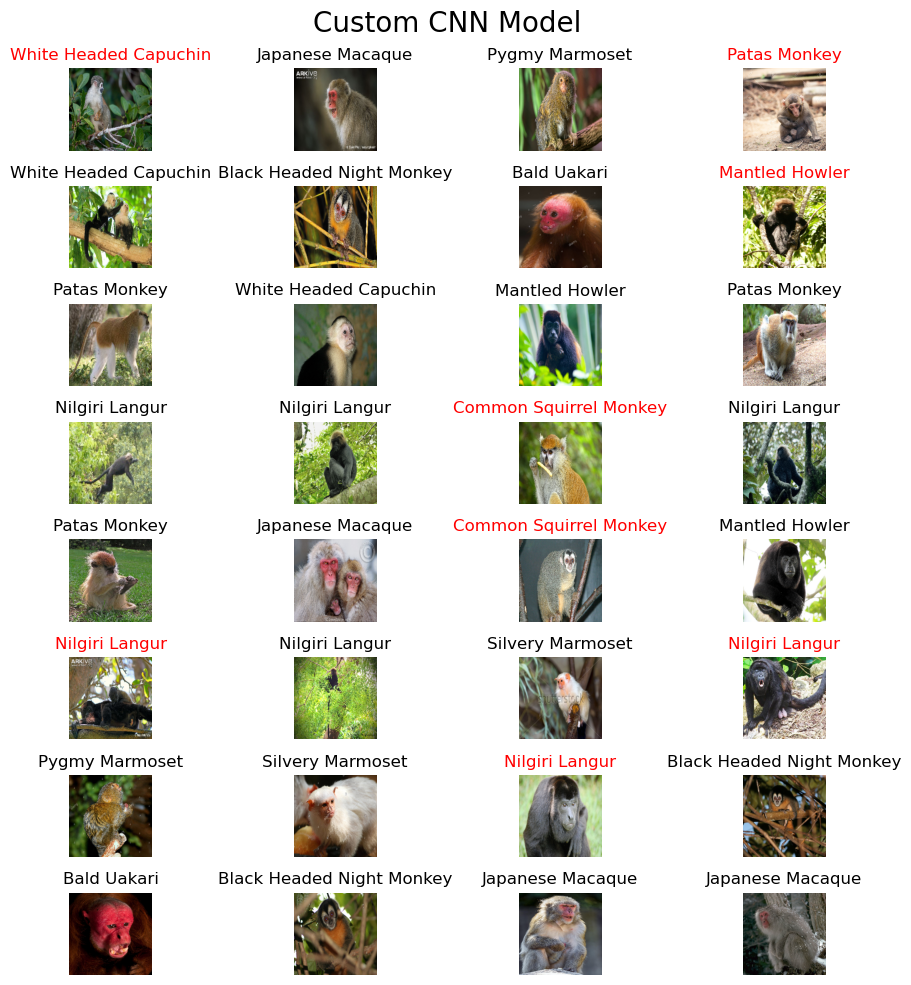

In this batch the model got 75.0% correct.


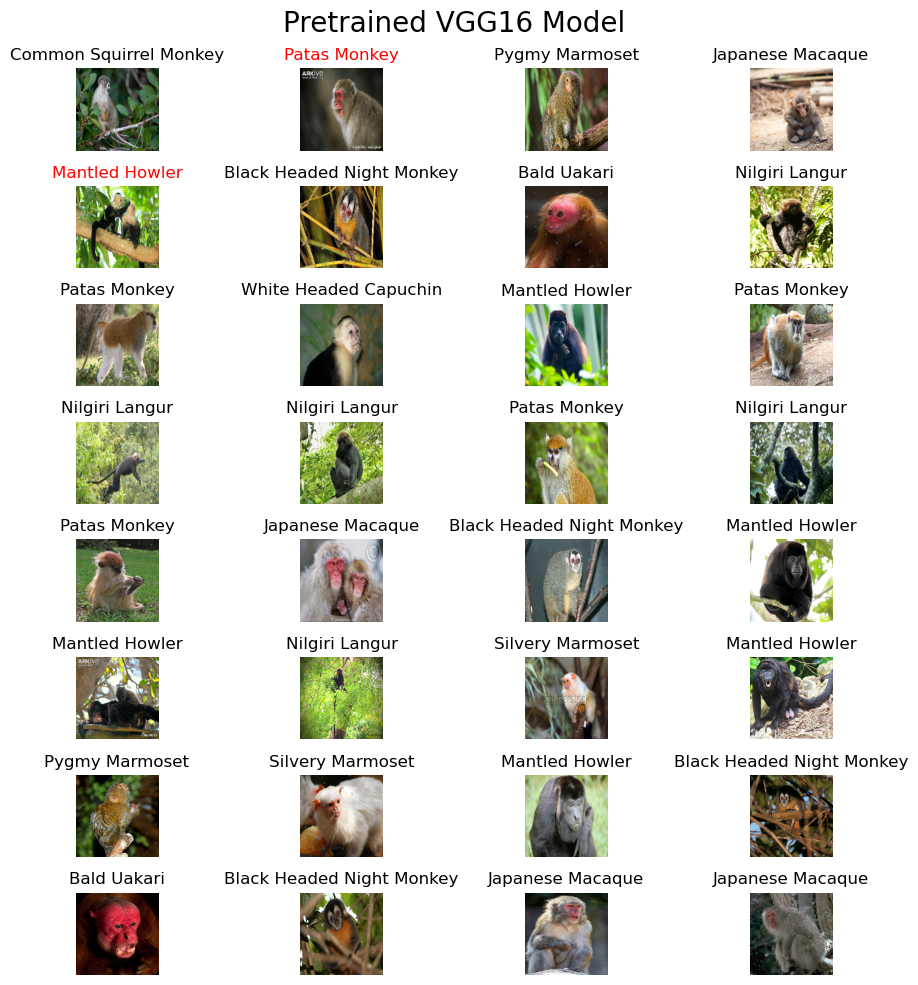

In this batch the model got 93.75% correct.


In [8]:
x_val_batch, y_val_batch = next(validation_generator)
batch_size = x_val_batch.shape[0]

def plot_predictions(model, title):
    batch_incorrect_count = 0
    fig, ax = plt.subplots(int(batch_size / 4), 4, figsize = (10,10))
    fig.suptitle(title, fontsize = 20)
    ax = ax.flatten()
    for i in range(batch_size):
        x_img = np.expand_dims(x_val_batch[i], axis=0) 
        y = np.argmax(tf.nn.softmax(model.predict(x_img, verbose = 0)))
        label_color = "black"
        if y != np.expand_dims(y_val_batch[i], axis = 0):
            label_color = "red"
            batch_incorrect_count += 1
        ax[i].imshow(x_val_batch[i])
        ax[i].set_title(species_dictionary.get(y, 0), color = label_color)
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()
    percent_correct = (batch_size - batch_incorrect_count) / batch_size * 100
    print(f"In this batch the model got {percent_correct}% correct.")
# CNN Model
plot_predictions(model, "Custom CNN Model")
# Pretrained Model
plot_predictions(pretrained_model, "Pretrained VGG16 Model")